In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import norm
%matplotlib inline

The great advantage especially with deep learning is that even though it is a heavily mathematical discipline, thanks to online courses and tutorials which focus on intuition as well as powerful open source tools and ready to use models, you can accomplish a lot even without understanding the mathematics. However I've found it both interesting and incredibly helpful to learn or re-learn various bits of theory. 

In this series of blogposts, I'm going to delve into theory and mathematics that is relevant for deep learning. This could be the theory behind a particular deep learning model but also, more broadly, topics in probability theory, linear algebra, theoretical machine learning, traditional machine learning methods, etc. I'm not striving for mathematical rigour but a focus on derivation over intuition. 

My goal in learning the mathematics is to become better at building models so there will be plenty of code examples and I will always link it to topics in deep learning that you will, hopefully, be able to understand better.

In this post we will cover variational inference and in a the next post we will look at how it relates to the variational auto-encoder. Variational inference is a method which is used to approximate distributions over latent variables, given a set of data points. It has also been used in Bayesian deep learning and forms a starting point for the VAE. 

### The problem

As always we have some datapoints and we'd like to do something we them. We'll come to specific examples in a moment. For now, say we have $n$ datapoints that we denote as $\mathbf{x} = \{\mathbf{x}_1 \ldots \mathbf{x}_n$\}. We also have, associated with these, latent variables $\mathbf{z}_1 \ldots \mathbf{z}_n$. 

[Write about latent variables]

$\mathbf{x}_i$ are distributed as $p(\mathbf{x}_i|\mathbf{z}_i, \theta)$. $\mathbf{z}_i$ in turn are distributed according to $p(\mathbf{z}_i| \theta)$. So for generating each datapoint, firstly a  value of $\mathbf{z}_i$ is selected from $p(\mathbf{z}_i| \theta)$. We can only observe the data points $\mathbf{x}$ but we would like to find the posterior distribution over $\mathbf{z}$ i.e. $p(\mathbf{z}|\mathbf{x}, \theta)$. We can also have a more general version of this problem where $\theta$ is not given so we actually want to find $p(\mathbf{z}, \theta|\mathbf{x})$.

[Illustration]

### Mixture of Gaussians

Let us see an example of this data-generating process in action. You may be familiar with Gaussian mixture models. Briefly, the datapoint $\mathbf{x}^{(i)} $ is considered to belong to any of $K$ different Gaussians where the latent variable $z^{(i)} \in \{1 \ldots K\}$ indicates the Gaussian from which $\mathbf{x}^{(i)} $ is drawn. Therefore $p(z^{(i)} ; \theta)$ is a categorical distribution [add hyperlink], with probabilities $\pi_1 \ldots \pi_K$ where:

$$p(z^{(i)}  = k; \theta) = \pi_k$$  
$$\sum_k{\pi_k}=1$$

And for $\mathbf{x}^{(i)} $ we have:

$$p(\mathbf{x}^{(i)} |z^{(i)}  = k;\theta) = \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}_k, \Sigma_k)$$

The parameters $\theta$ consist of $\pi_k$, $\mathbf{\mu}_k$ and $\Sigma_k$.

To get a feel for the data-generating process let's now generate some data for 1-D Gaussians with $k=3$. Note that the categorical distribution is a special case of the multinomial distribution when $n=1$ and `np.random.multinomial` returns a one-hot vector for each sample so we take the argmax to get scalar values for $z^{(i)} $. 

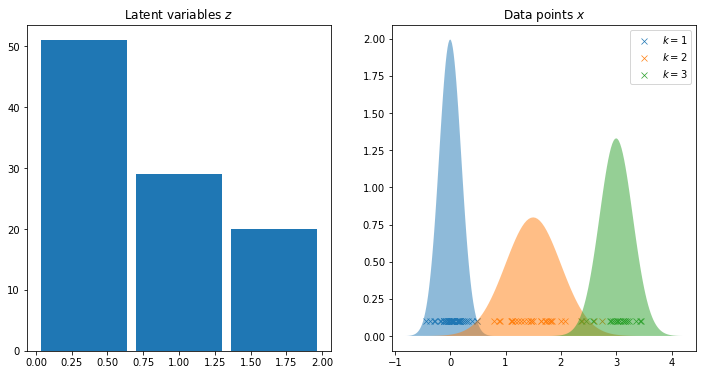

In [2]:
np.random.seed(1)
plt.figure(figsize=(12,6))


#PARAMETERS
pi = [0.5,0.3,0.2] #Prior probabilities for z
mu = np.array([0,1.5,3])
std = np.array([0.2, 0.5, 0.3])

#GENERATE LATENT VARIABLES

#The categorical distribution is a special case of the multinomial distribution when n = 1.
#np.random.multinomial returns a one-hot vector for each sample hence the argmax.
def categorical(pvals, size):
    onehot = np.random.multinomial(n=1, pvals=pvals, size=size)
    return np.argmax(onehot, axis=1)

z = categorical(pvals=pi, size=100) #Samples for z 
plt.subplot(1,2,1)
plt.hist(z, bins=3, rwidth=0.9)
plt.title('Latent variables $z$')

#GENERATE DATAPOINTS
x = np.random.normal(loc=mu[z], scale=std[z])

plt.subplot(1,2,2)
for i, (m, s) in enumerate(zip(mu, std)):
    diff = 4*s
    a = np.arange(m-diff, m+diff, 2*diff/100)
    poly = plt.fill(a, norm.pdf(a, loc=m, scale=s), alpha=0.5)[0]
    x_in_gaussian = x[z==i]
    plt.scatter(x_in_gaussian, 0.1*np.ones_like(x_in_gaussian), 
                color=poly.get_facecolor(),  linewidth=0.7, marker='x', alpha=1, label='$k={}$'.format(i+1))
    
plt.title('Data points $x$')
plt.legend();

Of course in practice we only have access to the points $\mathbf{x}$ and need to infer values or a distribution over $z$, $\mu_k$, $\sigma_k^2$ and $\pi_k$. Notice that here we want to find $p(\mathbf{z}, \theta|\mathbf{x})$ rather than $p(\mathbf{z}|\mathbf{x}, \theta)$. If we knew these values, then we could cluster each datapoint by assigning it to the Gaussian under which its probability is the highest. This could be done in an unsupervised setting when our datapoints are unlabelled as well as with labelled data, by trying to fit a mixture of K Gaussians corresponding to K classes. For example the plot below shows datapoints from the famous iris dataset, using only two out the four attributes.

What is more, once we fit a distribution to the data, we can generate new examples. It might not seem particularly interesting to generate examples of the toy data we have been considering but we shall see how, using VAEs, we can generate new images, definitely more exciting and useful.

In many cases, including mixtures of Gaussians, it turns out that we can't analytically solve for a distribution over $\mathbf{z}$ but need to resort to other methods, such as variational inference.

### Image denoising 

Let's look at another example where we would like to find a distribution over latent variables corresponding to a set of datapoints. We have a grayscale image which we have binarised so that the pixel values like between 0 and 1 for simplicity in calculations. We have added noise to the image by sampling a value from a normal distribution centred at the original pixel value.

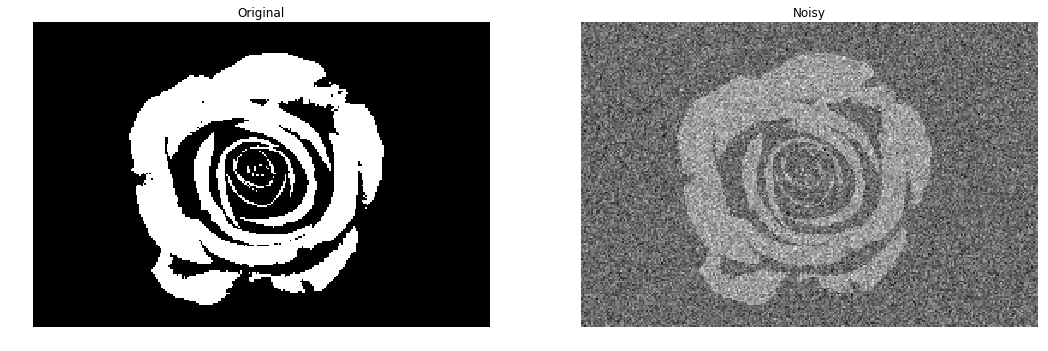

In [3]:
plt.figure(figsize=(18,9))
img = plt.imread('rose.jpeg')[...,0][::16, ::16]
num_pixels = img.size
m = np.mean(img)
img_minus_plus = 1*(img > 128) - 1*(img <= 128) #Make the values either -1 or 1
sigma = 1
img_noised =  np.random.normal(loc = img_minus_plus, scale=sigma)

for i, (im, title) in enumerate(zip([img_minus_plus, img_noised], ['Original', 'Noisy'])):
    plt.subplot(1,2,i+1)
    plt.imshow(im, 'gray')
    plt.title(title)
    plt.axis('off');


Here the datapoints are the pixel values of the noisy image $\mathbf{x}^{(i)}$. The latent variables $\mathbf{z}^{(i)}$ are the original values of these points. Let us consider an image of size $H \times W = D$. First we define a set $N_i$ for each pixel which contains the indicies of all the neighbouring pixels. We then propose the following model:

$$p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})$$

$$p(\mathbf{z}) \propto \exp\left(\frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j\right), W_{ij} = W_{ji}$$

$$p(\mathbf{x}\vert\mathbf{z}) = \prod_i p(\mathbf{x}_i\vert\mathbf{z}_i)$$

Each noisy pixel depends on the original pixel value in some way. For example above we use a normal distribution centred on $z_i$. It will be convenient to write this as the exponential of the log of the distribution, where we write it only as a function of $z_i$ since $x_i$ are known:

$$p(\mathbf{x}\vert\mathbf{z}) = \exp\left(\sum_i L_i(z_i)\right)$$

To calculate the posterior $p(\mathbf{z}\vert\mathbf{x}) = \frac{p(\mathbf{x}, \mathbf{z})}{p(\mathbf{x})}$ we need to calculate $p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})$, which requires summing over all the $2^D$ possible values of $\mathbf{z}$, which is intractable for arbitrary image sizes.


### Variational inference

#### The problem

Let us now state our problem in general terms. As mentioned earlier we want to find the posterior distribution over the latent variables $\mathbf{z}$ $p(\mathbf{z}|\mathbf{x}, \theta)$, or the joint the posterior distribution over the $\mathbf{z}$ as well as the paramaters $\theta$ $p(\mathbf{z}, \theta|\mathbf{x})$. For simplicity we will consider $p(\mathbf{z}|\mathbf{x},\theta)$ for the moment. Using Bayes rule we can write this as:

$$p(\mathbf{z}|\mathbf{x}, \theta) = \frac{p(\mathbf{x}|\mathbf{z}, \theta)p(\mathbf{z}|\theta)}{p(\mathbf{x}|\theta)}$$

As we saw in the examples, the problem with finding $p(\mathbf{z}|\mathbf{x})$ for arbitrary distributions $p(\mathbf{x}|\mathbf{z})$ and $p(\mathbf{z})$ is that it may not be possible to calculate the denominator $p(\mathbf{x})$ analytically. 

#### How variational inference approaches the problem 

Variational inference instead picks an alternative distribution $q(\mathbf{z})$ and optimises its parameters, which we denote by $\phi$, until this distribution is close to $p(\mathbf{z}|\mathbf{x}; \theta).$ The closeness is measured by the KL-divergence between $q(\mathbf{z})$ and $p(\mathbf{z}|\mathbf{x}; \theta)$:

$$D_{KL}(q||p) = E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x}, \theta)}\right)\right] = E_q\left[\log(q(\mathbf{z})) - \log(p(\mathbf{z}|\mathbf{x}, \theta))\right]$$

The KL-divergence is always non-negative and equal to 0 only when $q = p$. Now note that $D_{KL}(p||q) \neq D_{KL}(q||p)$ for $q \neq p$ so using $D_{KL}(p||q)$ as the distance metric would lead to different results. 

But notice that even $D_{KL}(p||q)$ demands knowledge of the posterior $p(\mathbf{z}|\mathbf{x}, \theta)$. However it turns out that we can indirectly minimise $D_{KL}(q||p)$ without having to calculate it explicitly. We instead minimise $E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}, \theta)}\right)\right]$, which looks similar to the KL divergence except that the denominator of the logterm contains $p(\mathbf{x},\mathbf{z}, \theta) = p(\mathbf{x}|\mathbf{z}, \theta)p(\mathbf{z}, \theta)$. This is the unnormalised posterior, which we assume that we can calculate.

Minimising this expectation with respect to $q$ minimises $D_{KL}(q||p)$ because:

$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right]
= E_q[\log(q(\mathbf{z}))] - E_q[\log(p(\mathbf{z}|\mathbf{x}, \theta)p(\mathbf{x}| \theta))]
\\= E_q[\log(q(\mathbf{z}))] - E_q[\log(p(\mathbf{z}|\mathbf{x}, \theta))] -  E_q[\log(p(\mathbf{x}| \theta))]
\\= E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x}, \theta)}\right)\right] -  E_q[\log(p(\mathbf{x}| \theta))]
\\= D_{KL}(q||p) - E_q[\log(p(\mathbf{x}| \theta))]$$ 


In other words this is $D_{KL}(q||p)$ plus a term that is constant with respect to $q$, which means

$$q^* = \arg\min_q E_q\left[{\log(q(\mathbf{z}))}/{p(\mathbf{x}, \mathbf{z}| \theta)}\right]
 = \arg\min_q D_{KL}(q||p)$$ 
    
so that finding $q$ which minimises the term pulls $q$ closer to $p(\mathbf{x}, \mathbf{z}| \theta)$ which is what we desire.

Since $0 \leq p(\mathbf{x}| \theta)) \leq 1$, $-\log(p(\mathbf{x}| \theta)) \geq 0$, which means that $D_{KL}(q||p)$ is the lower bound of the term we are trying to optimise 

$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right] \geq D_{KL}(q||p)$$

We denote the 

# Mean field method

We assume that the distributions for each latent variable $z_j$ is independent so that $q$ can be expressed as the product over distributions $q_j(z_j)$:

$$q(\mathbf{z}) = \prod_j q_j(z_j)$$


$$E_q\left[\log\left(\frac{q(\mathbf{z})}{p(\mathbf{x}, \mathbf{z}| \theta)}\right)\right]
=E_q\left[\log\left(\prod_j q_j(z_j)\right) - \log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=E_q\left[\sum_j\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=\sum_jE_q\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
=\sum_jE_{q_j}\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\\
$$

since $\log(q_j(z_j))$ depends only on $z_j$.

Now let us consider this as a function of $q_k$, $l(q_k)$:

$$l(q_k) =\sum_jE_{q_j}\left[\log(q_j(z_j))\right] - E_q\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]
\\=E_{q_k}\left[\log(q_k(z_k))\right] + \sum_{j\neq k}E_{q_j}\left[\log(q_j(z_j))\right] - E_{q_k}\left[E_{q_{-k}}\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\right]
\\= E_{q_k}\left[\text{const.} + \log(q_k(z_k)) - E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z}| \theta))\right]\right]$$

since $\sum_{j\neq k}E_{q_j}\left[\log(q_j(z_j))\right]$ is does not depend on $q_k$.

Solving for function which minimises $l(q_k)$, making it equal $0$:

$$\log(q_k(z_k)) = \text{const.} + E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z})\right]
\implies q_k(z_k) \propto \exp\left(E_{-q_k}\left[\log(p(\mathbf{x}, \mathbf{z})\right]\right)$$



#### How it works 

1. Propose a form for $q_j$. This can be a specific distribution like a Normal distribution or it can just be some function with parameters.
2. Derive expressions for $q_j$ using the proposed functions.
3. Find expressions for the $\phi_j$, the parameters of $q_j$, given $\phi_{-j}$
4. Initialise $\phi_j$ for all $j$ and then iteratively update $\phi_j$ until convergence.

### Application to the Ising model

1\. We propose a distribution $q_j(z_j; \mu_j)$ where \mu_j is the mean of $z_j$:

$$p(\mathbf{x}, \mathbf{z}) \propto \exp\left(\sum_i L_i(\mathbf{z}_i)\right)\exp\left(\frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j\right)$$

2\. First let us isolate the terms on the log of the above that depend on $z_l$

$$\log p(\mathbf{x}, \mathbf{z}) = \sum_i L_i(\mathbf{z}_i) + \frac{1}{2}\sum_{i=1}^D\sum_{j\in \mathcal{N}_i}W_{ij}z_iz_j
= \text{const.}  + L_l(\mathbf{z}_l) + \frac{1}{2}\sum_{j \in N_l}W_{lj}z_lz_j + \frac{1}{2}\sum_{j \in N_l}W_{jl}z_jz_l$$

Taking the expectation involves simply replacing $z_j, j \neq l$ with their means $\mu_j$:

$$E_{-q_{l}}\left[\log p(\mathbf{x}, \mathbf{z}) \right] = \text{const.} + L_l(\mathbf{z}_l)
+ z_l\sum_{j \in N_l}W_{lj}z_j 
\\ \implies q_l(z_l) \propto \exp\left(L_l(\mathbf{z}_l)
+ z_l\sum_{j \in N_l}W_{lj}z_j\right)$$

Let $n_l = \sum_{j \in N_l}W_{lj}z_j$. Then

$$q_l(1) \propto \exp\left(L_l(1) + n_l\right)$$

$$q_l(-1) \propto \exp\left(L_l(-1) - n_l\right)$$

$$q_1(1) = \frac{\exp\left(L_l(1) + n_l\right)}{\exp\left(L_l(1) + n_l\right) + \exp\left(L_l(-1) - n_l\right)} = \frac{1}{1 + \exp\left(-(L_l(1) - L_l(-1) + 2n_l)\right)} = \sigma(2a_l)$$

$$q_1(-1) = \frac{\exp\left(L_l(-1) - n_l\right)}{\exp\left(L_l(1) + n_l\right) + \exp\left(L_l(-1) - n_l\right)} = \frac{1}{1 + \exp\left(L_l(-1) - L_l(1) - 2n_l)\right)} = \sigma(-2a_l)$$

$$a_l = L_l(1) - L_l(-1) + 2n_l$$

3\. Using these values the mean $\mu_l$ can be found:

$$\mu_l = E_{q_l}[z_l] = \sigma(2a_l) - \sigma(-2a_l) = \tanh(a_l)$$

The subsequent steps will be in code.

### Code demo

In [4]:
#Define values
img = plt.imread('rose.jpeg')[...,0][::16, ::16]
num_pixels = img.size
img_minus_plus = 1*(img > 128) - 1*(img <=128) #Make the values either -1 or 1
sigma = 1
img_noised =  np.random.normal(loc = img_minus_plus, scale=sigma)

#Here Wij = 1 for all ij hence we simply sum over the neighbours
def logprob_z_term(img):
    delta = np.array([[0,-1],[0,1],[-1,0],[1,0]])
    inds = np.indices(img.shape).reshape((2,-1)).T
    #Get all neighbours
    neighbour_inds = inds[:,np.newaxis]+delta
    #Determine which pairs of indices that within bounds
    mask = np.all(np.logical_and(neighbour_inds >= 0, neighbour_inds < img.shape), axis=-1, keepdims=True)
    #Stack the indices in order retrieve the values, making those out of bounds [0,0] using mask
    inds_stacked = np.concatenate(neighbour_inds*mask, axis=0)
    #Retrieve and reshape
    neighbours = img[inds_stacked[:,0], inds_stacked[:,1]].reshape(mask.shape)
    #Sum for each location after making values out of bounds 0 by multiplying with mask
    result = np.sum(neighbours*mask, axis=1)/2
    return result.reshape(img.shape)

def logprob_x_given_z(z):
    return norm(loc=img_noised, scale=sigma).logpdf(z)

L_term = logprob_x_given_z(1) - logprob_x_given_z(-1)
    
#4. Initialise mu
mu0 = np.random.randint(-1,2,size=img.shape)
lm = 0.5
it = 0
errors = []
imgs = [img_noised]
#5. Update
while True:
    it +=1
    n = logprob_z_term(mu0)
    a = L_term + 2*n

#As suggested in Murphy, we will using an exponential moving average rather than just assigning the new value
    mu = (1-lm)*mu0 + lm*np.tanh(a)
    errors.append(np.max((mu0-mu)**2))
    if it<25:
        imgs.append(mu)
    sys.stdout.write('\rIter %i, error %2.9f'%(it,errors[-1]))
    if errors[-1] < 1e-9:
        break
    mu0 = mu


Iter 352, error 0.000000001

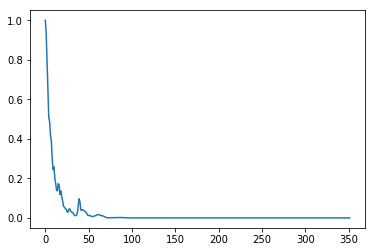

In [5]:
plt.plot(errors)

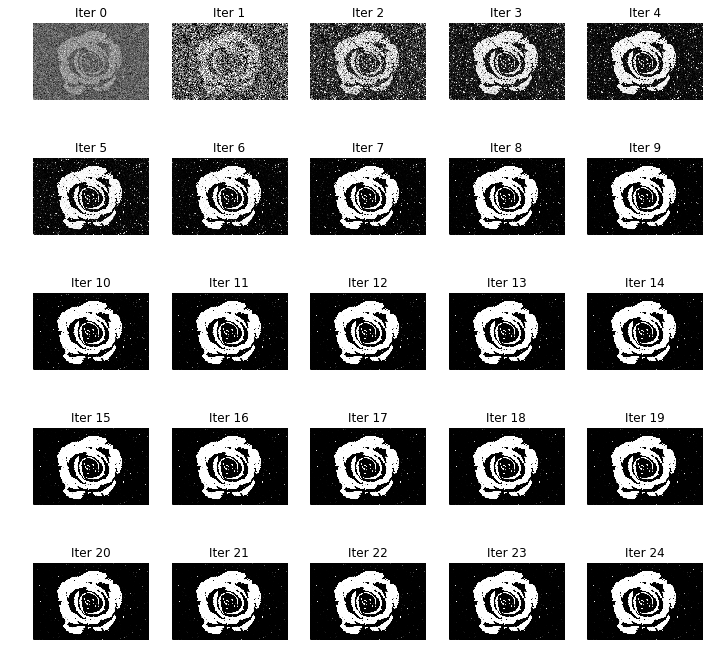

In [6]:
plt.figure(figsize=(12,12))
for i, im in enumerate(imgs):
    plt.subplot(5,5,i+1)
    plt.imshow(im, 'gray')
    plt.title('Iter %i'%(i))
    plt.axis('off');

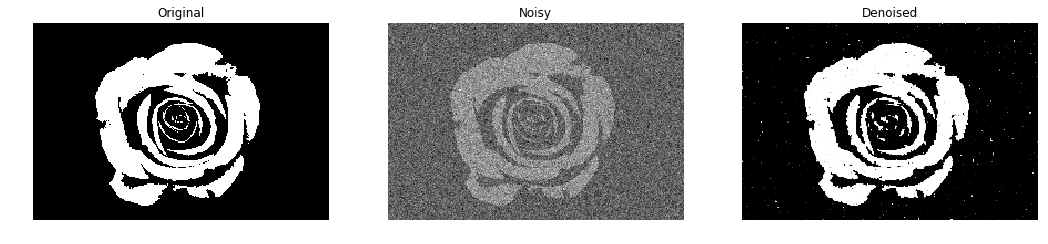

In [7]:
plt.figure(figsize=(18,6))
for i, (im, title) in enumerate(zip([img_minus_plus, img_noised, mu], ['Original', 'Noisy', 'Denoised'])):
    plt.subplot(1,3,i+1)
    plt.imshow(im, 'gray')
    plt.title(title)
    plt.axis('off');


# Summary 

In this blogpost we have learned that variational inference is a method used to approximate intractable posterior distributions, which involves choosing a different distribution and optimising its parameters to pull it closer to the true distribution.  We can use it to approximate distributions over unseen variables as well as parameters. We have derived the equations for the mean-field method and applied them to the examples of GMMs and image denoising. In addition we have considered some of the limitations of this method. 

In the next blogpost, we will look at variational methods in the context of deep learning and learn about variational auto-encoders. 

### The lower bound


One example you may be familiar with is mixture of Gaussians, where each datapoint has been drawn from any of k different Gaussians. In this case the latent variable zi={1,...,k}  indicates the Gaussian from which xi has been drawn. If we find p(z|x;t), then we could assign each datapoint to a cluster c_i at which the posterior is maximised i.e. c_i = argmax_k p(zi = k|x;t). 

Another example is image denoising. Here y_i are the pixel values of a noisy image whilst x_i are the original pixel values. Calculating the posterior would let us estimate the original pixel values and thereby denoise the image. 

Using Bayes rule we can write the posterior as:

	p(z|x; t) = p(x|z; t)p(z; t)/p(x; t)  


The problem with finding p(z|x; t) for arbitrary distributions p(x|z; t) and p(z; t) is that it may not be possible to analytically calculate the denominator. 

For the examples above … 

To find the denominator p(x; t)  = 𝝨p(x|z; t)p(z; t) would require summing over all possible values of z. In general we need to find some way to approximate the distribution. 

There are various ways to approximate these distributions. Variational inference approaches this task by picking an alternative distribution q(z) and optimising its parameters until this distribution close to p(z|x; t). The closeness is measured by the KL-divergence between q(z) and p(z|x; t), KL(q||p). KL(p||q) is not equal to KL(q||p) for q != p. Since KL(p||q) requires taking an expectation with respect to p(z|x; t), which we are assuming we can’t find in the first place, we go with KL(q||p). In fact as you can see even this requires knowledge of the posterior, which appears in the log-term. However we can get around this by minimising E_q[log(q(z)/p(x,z;t)], where p(x,z;t) = p(x|z; t)p(z; t) is the unnormalised posterior, which we can normally calculate.That is because:

	E_q[log(q(z)/p(x,z;t)] 
= E_q[log(q(z))] - E_q[log(p(z|x;t)*p(x;t))] 
= E_q[log(q(z))] - E_q[p(z;t)] -  E_q[log(p(x;t))]
= E_q[log(q(z))/log(p(z|x;t))] -  E_q[log(p(x;t))] 
= KL(q||p) -  log(p(x;t)) (since p(x;t) is not a function of z)

	L(q) = -KL(q||p) +  log(p(x;t))

The KL-divergence is always >= 0 so the above term is upper-bounded by log(p(x;t)), the log of the normalization term for the posterior, which is constant with respect to q(z). We maximise the lower bound with respect to the distribution q(z) which will minimise the KL-divergence and make q(z) closer to p(z|x;t). The optimal distribution is q(z) = p(z|x;t) for which KL(q||p) = 0. 

We haven’t really discussed where q comes from. We can explicitly specify a form such as a Normal distribution but we could also let the form of distribution emerge from the optimisation. We will see an example of each below. 

One of the most common forms of variational inference uses the mean field method. Here, q is modelled as the product of distributions over each z_j. For example, for the mixture of Gaussians, z ={...} so that q is …, where we explicitly specify a form for q. For denoising example, q = … - here a form for q is not specified in advance. 

[Mean field update derivation]

[Mean field updates for Ising and GMM]
